In [40]:
import auxiliary as aux
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, AutoTokenizer, DataCollatorForTokenClassification
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from tqdm import tqdm
from seqeval.metrics import classification_report
from kingbert import KingBert

all_labels = [
    'B-STREET', 'B-CITY', 'I-DATE', 'B-PASS', 'I-CITY', 'B-TIME', 'B-EMAIL', 'I-DRIVERLICENSE',
    'I-POSTCODE', 'I-BOD', 'B-USERNAME', 'B-BOD', 'B-COUNTRY', 'B-SECADDRESS', 'B-IDCARD',
    'I-SOCIALNUMBER', 'I-PASSPORT', 'B-IP', 'O', 'B-TEL', 'B-SOCIALNUMBER', 'I-TIME', 'B-BUILDING',
    'B-PASSPORT', 'I-TITLE', 'I-SEX', 'I-STREET', 'B-STATE', 'I-STATE', 'B-TITLE', 'B-DATE',
    'B-GEOCOORD', 'I-IDCARD', 'I-TEL', 'B-POSTCODE', 'B-DRIVERLICENSE', 'I-GEOCOORD',
    'I-COUNTRY', 'I-EMAIL', 'I-PASS', 'B-SEX', 'I-USERNAME', 'I-BUILDING', 'I-IP',
    'I-SECADDRESS', 'B-CARDISSUER', 'I-CARDISSUER'
]

id2label = {i: l for i, l in enumerate(all_labels)}
label2id = {v: k for k, v in id2label.items()}
n_labels = len(all_labels)

In [41]:
def compute_all_metrics(model, tokenizer, dataset, batch_size=8):
    model = model.to('cuda')
    model.eval()

    # Drop non-numeric columns
    dataset = dataset.remove_columns(["source_text", "tokens"])

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=DataCollatorForTokenClassification(tokenizer, return_tensors="pt")
    )

    all_predictions = []
    all_labels = []
    all_predictions_text = []
    all_labels_text = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to('cuda')
            attention_mask = batch["attention_mask"].to('cuda')
            labels = batch["labels"]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            labels = labels.numpy()

            all_predictions.extend(preds)
            all_labels.extend(labels)

            for pred_seq, label_seq in zip(preds, labels):
                pred_labels = []
                true_labels = []
                for p, l in zip(pred_seq, label_seq):
                    if l == -100:
                        continue
                    pred_labels.append(id2label[p])
                    true_labels.append(id2label[l])
                all_predictions_text.append(pred_labels)
                all_labels_text.append(true_labels)

        
    print(classification_report(all_labels_text, all_predictions_text))

    return aux.compute_metrics(all_predictions, all_labels)

In [33]:
d_test = aux.json_to_Dataset("data/distilbert_test.json")
a_test = aux.json_to_Dataset("data/albert_test.json")
d_val= aux.json_to_Dataset("data/distilbert_val.json")
a_val = aux.json_to_Dataset("data/albert_val.json")

In [20]:
old_d1_model      = AutoModelForTokenClassification.from_pretrained('to_share/distilbert1')
old_d1_tokenizer  = AutoTokenizer.from_pretrained('to_share/distilbert1')
new_d1_model      = AutoModelForTokenClassification.from_pretrained('models/distilbert1')
new_d1_tokenizer  = AutoTokenizer.from_pretrained('models/distilbert1')

old_d2_model      = AutoModelForTokenClassification.from_pretrained('to_share/distilbert2')
old_d2_tokenizer  = AutoTokenizer.from_pretrained('to_share/distilbert2')
new_d2_model      = AutoModelForTokenClassification.from_pretrained('models/distilbert2')
new_d2_tokenizer  = AutoTokenizer.from_pretrained('models/distilbert2')

old_a_model      = AutoModelForTokenClassification.from_pretrained('to_share/albert1')
old_a_tokenizer  = AutoTokenizer.from_pretrained('to_share/albert1')
new_a_model      = AutoModelForTokenClassification.from_pretrained('models/albert1')
new_a_tokenizer  = AutoTokenizer.from_pretrained('models/albert1')


In [45]:
d_test = aux.json_to_Dataset_adv("data/distilbert_test_adv.json")
model = AutoModelForTokenClassification.from_pretrained('models/distilbert1')
tokenizer = AutoTokenizer.from_pretrained('models/distilbert1')
res = aux.compute_all_metrics(model, d_test)
res

Inference Progress: 100%|██████████| 962/962 [00:58<00:00, 16.39it/s]


{'precision': np.float64(0.49486963835155595),
 'recall': np.float64(0.6415176624509377),
 'f1': np.float64(0.5587313645427785),
 'accuracy': 0.9469328263624841,
 'confusion_matrix': array([[ 72,   0,   0, ...,   0,   0,   0],
        [  1, 122,   0, ...,   1,   0,   0],
        [  0,   0, 263, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  55,   0,   0],
        [  0,   0,   0, ...,   0, 608,   0],
        [  0,   0,   0, ...,   1,   0,  61]], shape=(41, 41))}

In [11]:
test = aux.json_to_Dataset_adv("data/albert_test_adv.json")
model = AutoModelForTokenClassification.from_pretrained('models/albert1')
tokenizer = AutoTokenizer.from_pretrained('models/albert1')
res = aux.compute_all_metrics(model, test)
res

Inference Progress: 100%|██████████| 962/962 [00:56<00:00, 17.15it/s]


{'precision': np.float64(0.561275881365417),
 'recall': np.float64(0.6561273440907108),
 'f1': np.float64(0.6050065346335579),
 'accuracy': 0.9589094918820263,
 'confusion_matrix': array([[125,   7,   0, ...,   1,   0,   0],
        [  0, 134,   0, ...,   0,   0,   0],
        [  0,   0, 269, ...,   0,   1,   0],
        ...,
        [  0,   0,   0, ...,  33,   0,   0],
        [  0,   0,   0, ...,   0, 607,   0],
        [  0,   0,   0, ...,   0,   0,  53]], shape=(41, 41))}

In [34]:
res1_old = compute_all_metrics(old_d1_model, old_d1_tokenizer, d_test)
res1_new = compute_all_metrics(new_d1_model, new_d1_tokenizer, d_test)
res2_old = compute_all_metrics(old_d2_model, old_d2_tokenizer, d_test)
res2_new = compute_all_metrics(new_d2_model, new_d2_tokenizer, d_test)


Evaluating: 100%|██████████| 290/290 [00:05<00:00, 53.65it/s]


               precision    recall  f1-score   support

          BOD       0.97      0.98      0.97       548
     BUILDING       0.97      0.99      0.98       547
         CITY       0.97      0.99      0.98       536
      COUNTRY       0.97      0.96      0.96       429
         DATE       0.92      0.95      0.94       500
DRIVERLICENSE       0.92      0.95      0.94       673
        EMAIL       0.97      0.99      0.98       837
     GEOCOORD       0.98      0.98      0.98        45
       IDCARD       0.96      0.89      0.93       759
           IP       0.99      0.99      0.99       611
         PASS       0.96      0.96      0.96       446
     PASSPORT       0.90      0.97      0.93       693
     POSTCODE       0.97      0.98      0.97       530
   SECADDRESS       0.98      0.97      0.97       204
          SEX       0.99      1.00      0.99       510
 SOCIALNUMBER       0.93      0.94      0.94       718
        STATE       0.99      0.99      0.99       527
       ST

Evaluating: 100%|██████████| 290/290 [00:05<00:00, 52.54it/s]


               precision    recall  f1-score   support

          BOD       0.98      0.97      0.97       548
     BUILDING       0.98      0.98      0.98       547
         CITY       0.96      0.96      0.96       536
      COUNTRY       0.96      0.96      0.96       429
         DATE       0.91      0.93      0.92       500
DRIVERLICENSE       0.93      0.91      0.92       673
        EMAIL       0.97      0.99      0.98       837
     GEOCOORD       0.88      0.96      0.91        45
       IDCARD       0.92      0.92      0.92       759
           IP       0.98      0.99      0.98       611
         PASS       0.93      0.92      0.92       446
     PASSPORT       0.92      0.93      0.93       693
     POSTCODE       0.94      0.97      0.96       530
   SECADDRESS       0.96      0.96      0.96       204
          SEX       0.97      0.99      0.98       510
 SOCIALNUMBER       0.94      0.94      0.94       718
        STATE       0.97      0.98      0.98       527
       ST

Evaluating: 100%|██████████| 290/290 [00:05<00:00, 51.07it/s]


               precision    recall  f1-score   support

          BOD       0.97      0.99      0.98       548
     BUILDING       0.99      0.99      0.99       547
         CITY       0.98      0.99      0.98       536
      COUNTRY       0.97      0.98      0.97       429
         DATE       0.97      0.94      0.96       500
DRIVERLICENSE       0.96      0.95      0.95       673
        EMAIL       0.98      0.99      0.99       837
     GEOCOORD       0.96      0.96      0.96        45
       IDCARD       0.94      0.95      0.95       759
           IP       0.99      0.99      0.99       611
         PASS       0.98      0.98      0.98       446
     PASSPORT       0.95      0.96      0.95       693
     POSTCODE       0.98      0.98      0.98       530
   SECADDRESS       0.99      0.97      0.98       204
          SEX       0.99      1.00      0.99       510
 SOCIALNUMBER       0.95      0.95      0.95       718
        STATE       0.99      0.99      0.99       527
       ST

Evaluating: 100%|██████████| 290/290 [00:05<00:00, 51.55it/s]


               precision    recall  f1-score   support

          BOD       0.96      0.97      0.96       548
     BUILDING       0.99      0.98      0.99       547
         CITY       0.96      0.96      0.96       536
      COUNTRY       0.95      0.96      0.96       429
         DATE       0.92      0.93      0.92       500
DRIVERLICENSE       0.91      0.94      0.92       673
        EMAIL       0.97      0.99      0.98       837
     GEOCOORD       0.92      0.98      0.95        45
       IDCARD       0.91      0.93      0.92       759
           IP       0.97      0.99      0.98       611
         PASS       0.93      0.91      0.92       446
     PASSPORT       0.93      0.91      0.92       693
     POSTCODE       0.94      0.96      0.95       530
   SECADDRESS       0.97      0.96      0.96       204
          SEX       0.98      0.99      0.98       510
 SOCIALNUMBER       0.92      0.93      0.93       718
        STATE       0.97      0.98      0.98       527
       ST

In [35]:
res1_old

{'precision': np.float64(0.9571338184118949),
 'recall': np.float64(0.9670768739012306),
 'f1': np.float64(0.9620796565704747),
 'accuracy': 0.9956496368619033,
 'confusion_matrix': array([[ 527,    3,    0, ...,    0,    0,    0],
        [   0,  529,    0, ...,    0,    0,    0],
        [   0,    0,  748, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0, 1599,    0],
        [   0,    0,    0, ...,    0,    0,  210]], shape=(45, 45))}

In [36]:
res1_new

{'precision': np.float64(0.9448520710059172),
 'recall': np.float64(0.9570081508710244),
 'f1': np.float64(0.9508912620588352),
 'accuracy': 0.9939824318269441,
 'confusion_matrix': array([[ 525,    1,    0, ...,    0,    0,    0],
        [   7,  518,    0, ...,    0,    0,    0],
        [   0,    0,  728, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0, 1588,    0],
        [   0,    0,    0, ...,    0,    0,  211]], shape=(45, 45))}

In [37]:
res2_old

{'precision': np.float64(0.9701266629490959),
 'recall': np.float64(0.9731500719194502),
 'f1': np.float64(0.9716360154785176),
 'accuracy': 0.996696850024487,
 'confusion_matrix': array([[ 526,    3,    0, ...,    0,    0,    0],
        [   0,  528,    0, ...,    0,    0,    0],
        [   0,    0,  735, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0, 1610,    0],
        [   0,    0,    0, ...,    0,    0,  210]], shape=(45, 45))}

In [38]:
res2_new

{'precision': np.float64(0.9450027696446942),
 'recall': np.float64(0.9542911938628735),
 'f1': np.float64(0.9496242694127471),
 'accuracy': 0.9938417614021194,
 'confusion_matrix': array([[ 520,    5,    0, ...,    0,    0,    0],
        [   7,  519,    0, ...,    0,    0,    0],
        [   0,    0,  713, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0, 1598,    0],
        [   0,    0,    0, ...,    0,    0,  209]], shape=(45, 45))}

In [39]:
resa_old = compute_all_metrics(old_a_model, old_a_tokenizer, a_test)
resa_new = compute_all_metrics(new_a_model, new_a_tokenizer, a_test)


Evaluating: 100%|██████████| 290/290 [00:17<00:00, 17.03it/s]


               precision    recall  f1-score   support

          BOD       0.95      0.99      0.97       548
     BUILDING       0.99      0.99      0.99       547
         CITY       0.97      0.96      0.97       536
      COUNTRY       0.98      0.92      0.95       429
         DATE       0.94      0.93      0.94       500
DRIVERLICENSE       0.96      0.93      0.95       673
        EMAIL       0.98      0.99      0.98       837
     GEOCOORD       0.98      0.98      0.98        45
       IDCARD       0.93      0.94      0.93       759
           IP       1.00      0.99      0.99       611
         PASS       0.97      0.98      0.98       446
     PASSPORT       0.90      0.97      0.93       693
     POSTCODE       0.94      0.96      0.95       530
   SECADDRESS       0.99      0.97      0.98       204
          SEX       0.99      1.00      1.00       510
 SOCIALNUMBER       0.95      0.94      0.95       718
        STATE       0.99      0.97      0.98       527
       ST

Evaluating: 100%|██████████| 290/290 [00:17<00:00, 16.72it/s]


               precision    recall  f1-score   support

          BOD       0.97      0.97      0.97       548
     BUILDING       0.98      0.98      0.98       547
         CITY       0.96      0.96      0.96       536
      COUNTRY       0.95      0.97      0.96       429
         DATE       0.92      0.92      0.92       500
DRIVERLICENSE       0.93      0.93      0.93       673
        EMAIL       0.98      0.99      0.98       837
     GEOCOORD       0.86      0.96      0.91        45
       IDCARD       0.91      0.89      0.90       759
           IP       1.00      0.99      0.99       611
         PASS       0.97      0.96      0.97       446
     PASSPORT       0.89      0.89      0.89       693
     POSTCODE       0.94      0.95      0.95       530
   SECADDRESS       0.98      0.96      0.97       204
          SEX       0.97      0.99      0.98       510
 SOCIALNUMBER       0.89      0.93      0.91       718
        STATE       0.96      0.97      0.96       527
       ST

In [34]:
resa_old

{'precision': np.float64(0.9627888446215139),
 'recall': np.float64(0.9655585743966757),
 'f1': np.float64(0.9641717203957868),
 'accuracy': 0.995327419598763,
 'confusion_matrix': array([[ 520,    3,    0, ...,    0,    0,    0],
        [   1,  514,    0, ...,    0,    0,    0],
        [   0,    0,  721, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0, 1587,    0],
        [   0,    0,    0, ...,    0,    0,  210]], shape=(45, 45))}

In [35]:
resa_new

{'precision': np.float64(0.901991288114499),
 'recall': np.float64(0.9266421607799264),
 'f1': np.float64(0.9141505715411903),
 'accuracy': 0.9901542055831077,
 'confusion_matrix': array([[ 519,    8,    0, ...,    0,    0,    0],
        [   4,  510,    0, ...,    0,    0,    0],
        [   0,    0,  718, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0, 1614,    0],
        [   0,    0,    0, ...,    0,    0,  209]], shape=(45, 45))}

In [40]:
res1_new_val = compute_all_metrics(new_d1_model, new_d1_tokenizer, d_val)
res2_new_val = compute_all_metrics(new_d2_model, new_d2_tokenizer, d_val)


Evaluating: 100%|██████████| 261/261 [00:04<00:00, 56.25it/s]


In [41]:
res1_new_val

{'precision': np.float64(0.9496475327291037),
 'recall': np.float64(0.9642126789366053),
 'f1': np.float64(0.9568746829020801),
 'accuracy': 0.9950836075909099,
 'confusion_matrix': array([[ 467,    3,    0, ...,    0,    0,    0],
        [   4,  484,    0, ...,    0,    0,    0],
        [   0,    0,  633, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,   43,    0,    1],
        [   0,    0,    0, ...,    0, 1478,    0],
        [   0,    0,    0, ...,    0,    0,  209]], shape=(44, 44))}

In [42]:
res2_new_val

{'precision': np.float64(0.9509596840848563),
 'recall': np.float64(0.9625395054842908),
 'f1': np.float64(0.9567145562895552),
 'accuracy': 0.9950893915819794,
 'confusion_matrix': array([[ 465,    5,    0, ...,    0,    0,    0],
        [   3,  481,    0, ...,    0,    0,    0],
        [   0,    0,  638, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,   26,    0,    1],
        [   0,    0,    0, ...,    0, 1480,    0],
        [   0,    0,    0, ...,    0,    0,  207]], shape=(44, 44))}

In [46]:
resa_new_val = compute_all_metrics(new_a_model, new_a_tokenizer, a_val)

Evaluating: 100%|██████████| 261/261 [00:14<00:00, 17.76it/s]


In [47]:
resa_new_val

{'precision': np.float64(0.9123300090661831),
 'recall': np.float64(0.9353969139245213),
 'f1': np.float64(0.92371947861208),
 'accuracy': 0.9913471493600013,
 'confusion_matrix': array([[ 466,    3,    0, ...,    0,    0,    0],
        [   1,  476,    0, ...,    0,    0,    0],
        [   0,    0,  627, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,   29,    0,    1],
        [   0,    0,    0, ...,    0, 1484,    0],
        [   0,    0,    0, ...,    0,    0,  208]], shape=(44, 44))}

In [48]:
resac_new_val

{'precision': np.float64(0.9465077605321508),
 'recall': np.float64(0.9523145566090352),
 'f1': np.float64(0.949402279677509),
 'accuracy': 0.9944242326089848,
 'confusion_matrix': array([[ 466,    4,    0, ...,    0,    0,    0],
        [   2,  479,    0, ...,    0,    0,    0],
        [   0,    0,  630, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,   28,    0,    1],
        [   0,    0,    0, ...,    0, 1480,    0],
        [   0,    0,    0, ...,    0,    0,  206]], shape=(44, 44))}

In [16]:
conf = np.log(res['confusion_matrix'] + 0.01)

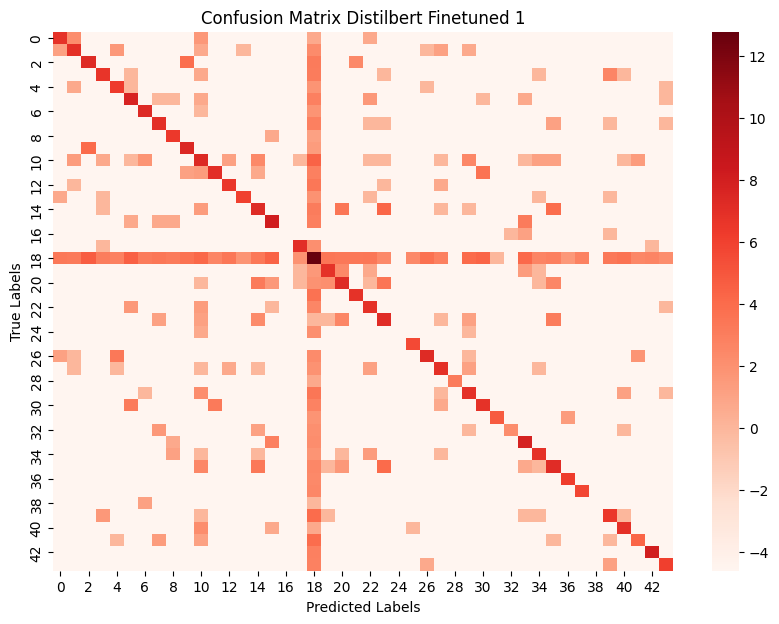

In [17]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf, cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Distilbert Finetuned 1')
plt.show()


In [9]:
# Define a test phrase with special tokens

test_phrase = "My name is Cubo, and my credit card is 4111-1111-1111-1111 issued by VISA."
test_phrase = test_phrase


# Tokenize the input
inputs = tokenizer.tokenize(test_phrase)
input_ids = torch.tensor([[101] + tokenizer.convert_tokens_to_ids(inputs) + [102]])
attention_mask = torch.tensor([1 for i in range(len(input_ids))]).unsqueeze(0)

print(input_ids)
print(attention_mask)

tensor([[  101,  2026,  2171,  2003, 21987,  2080,  1010,  1998,  2026,  4923,
          4003,  2003, 27517,  2487,  1011, 11118,  2487,  1011, 11118,  2487,
          1011, 11118,  2487,  3843,  2011,  9425,  1012,   102]])
tensor([[1]])


In [10]:
logits, predictions, predicted_token_class, inputs = aux.inference(model, input_ids, attention_mask)

print(predicted_token_class)


['O', 'O', 'O', 'O', 'B-USERNAME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SOCIALNUMBER', 'I-TEL', 'I-TEL', 'I-TEL', 'I-TEL', 'I-TEL', 'I-TEL', 'I-TEL', 'I-TEL', 'I-TEL', 'I-TEL', 'O', 'O', 'O', 'O', 'O']


In [47]:
# Get the tokens from the tokenizer
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Print results
print("Token\tPrediction")
print("-" * 30)
for token, prediction in zip(tokens, predicted_token_class):
    print(f"{token}\t{prediction}")

# Visualize the results with color coding
colored_text = []
current_entity = None
for token, label in zip(tokens, predicted_token_class):
    # Skip special tokens
    if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
        continue
        
    # Handle subword tokens (starting with ##)
    token_display = token.replace("##", "")
    
    if label == "O":
        # Not an entity
        colored_text.append(token_display)
        current_entity = None
    elif label.startswith("B-"):
        # Beginning of entity
        entity_type = label[2:]
        colored_text.append(f"\033[1m\033[91m{token_display}\033[0m")
        current_entity = entity_type
    elif label.startswith("I-"):
        # Inside an entity
        entity_type = label[2:]
        colored_text.append(f"\033[1m\033[91m{token_display}\033[0m")
        current_entity = entity_type

# Join tokens to form text (this is simplified and might not be perfect for all tokenizers)
reconstructed_text = "".join(colored_text).replace(" ##", "")
print("\nColored text (PII in red):")
print(reconstructed_text)

# Create a more readable visualization
print("\nDetected PII entities:")
entity_spans = []
current_entity = None
current_start = None

for i, (token, label) in enumerate(zip(tokens, predicted_token_class)):
    # Skip special tokens
    if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
        continue
        
    if label.startswith("B-"):
        # Beginning of a new entity
        if current_entity:
            # Save the previous entity
            entity_spans.append((current_start, i-1, current_entity))
        current_entity = label[2:]
        current_start = i
    elif label.startswith("I-"):
        # Inside an entity - continue
        pass
    elif label == "O":
        # Outside any entity
        if current_entity:
            # Save the previous entity
            entity_spans.append((current_start, i-1, current_entity))
            current_entity = None

# Add the last entity if there is one
if current_entity:
    entity_spans.append((current_start, len(tokens)-1, current_entity))

# Print the original text with highlighted entities
original_tokens = tokenizer.convert_tokens_to_string(tokens).split()
for start, end, entity_type in entity_spans:
    entity_text = " ".join(original_tokens[start:end+1])
    print(f"{entity_type}: {entity_text}")


Token	Prediction
------------------------------
[	O
C	O
L	O
S	O
]	B-USERNAME

Colored text (PII in red):
[CLS]

Detected PII entities:


TypeError: argument 'tokens': Can't extract `str` to `Vec`

In [8]:
model = AutoModelForTokenClassification.from_pretrained('distilbert_finetuned2')
tokenizer = AutoTokenizer.from_pretrained('distilbert_finetuned2')

In [9]:
res = aux.compute_all_metrics(model, data)
print(res)

Inference Progress: 100%|██████████| 4811/4811 [03:27<00:00, 23.20it/s]


{'precision': 0.6049911399881867, 'recall': 0.6627305079262374, 'f1': 0.6325459317585301, 'accuracy': 0.9642173775480993, 'confusion_matrix': array([[ 735,  138,    0, ...,    0,    0,    0],
       [ 290,  553,    0, ...,    0,    0,    0],
       [   0,    0, 1102, ...,    0,    0,    0],
       ...,
       [   1,    1,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0, 3132,    0],
       [   4,    0,    0, ...,    0,    0,   24]])}


In [10]:
conf = np.log(res['confusion_matrix'] + 0.01)

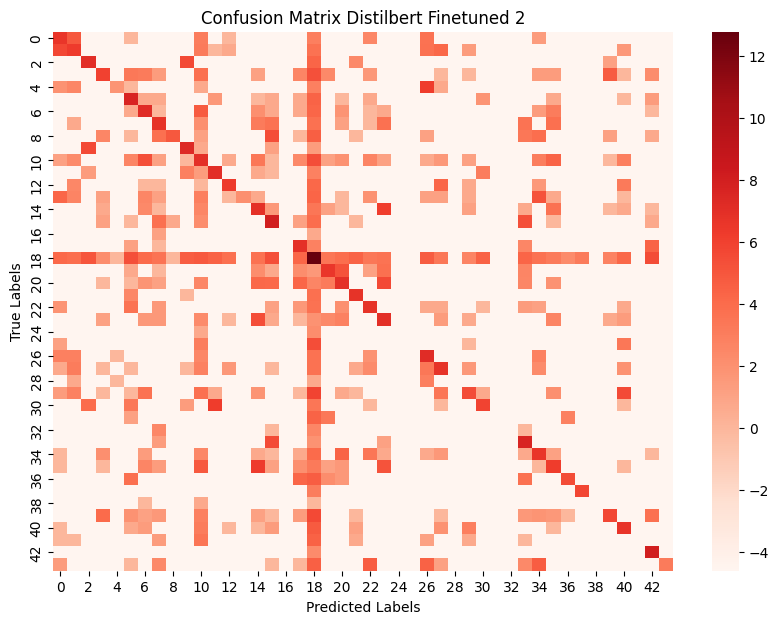

In [11]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf, cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Distilbert Finetuned 2')
plt.show()


In [28]:
test = aux.json_to_Dataset("data/albert_test.json")

In [29]:
data = [i for i in test]

In [30]:
model = AutoModelForTokenClassification.from_pretrained('albert_finetuned')
tokenizer = AutoTokenizer.from_pretrained('albert_finetuned')

In [15]:
res = aux.compute_all_metrics(model, data)
print(res)

Inference Progress: 100%|██████████| 4811/4811 [09:04<00:00,  8.83it/s]


{'precision': 0.8581946348149598, 'recall': 0.8862018764153995, 'f1': 0.8719734198117899, 'accuracy': 0.9870027144640001, 'confusion_matrix': array([[ 898,   57,    0, ...,    0,    0,    0],
       [   4,  980,    0, ...,    0,    0,    0],
       [   0,    0, 1297, ...,    0,    0,    0],
       ...,
       [   0,    1,    0, ...,    5,    0,    0],
       [   0,    0,    0, ...,    0, 3121,    0],
       [   0,    0,    0, ...,    0,    0,  392]])}


In [16]:
conf = np.log(res['confusion_matrix'] + 0.01)

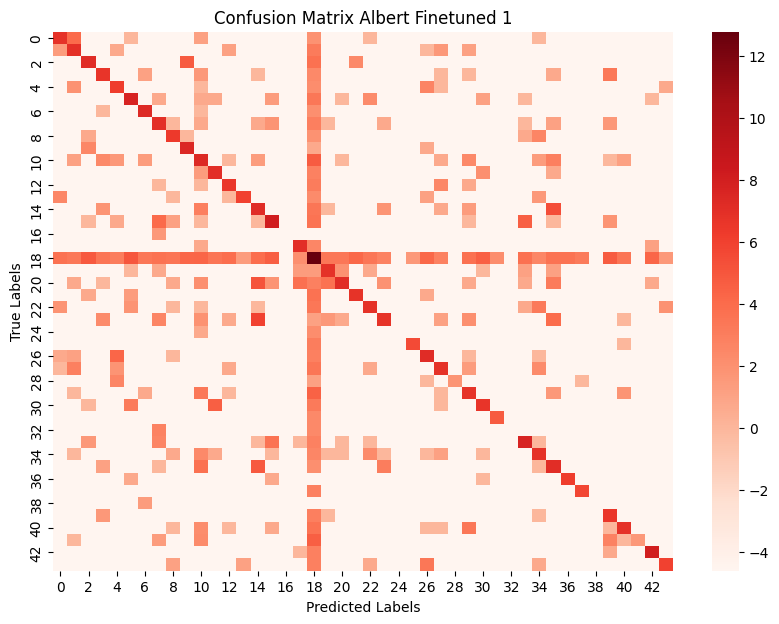

In [17]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf, cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Albert Finetuned 1')
plt.show()


In [18]:
model = AutoModelForTokenClassification.from_pretrained('albert_finetuned2')
tokenizer = AutoTokenizer.from_pretrained('albert_finetuned2')

In [19]:
res = aux.compute_all_metrics(model, data)
print(res)

Inference Progress: 100%|██████████| 4811/4811 [08:18<00:00,  9.65it/s]


{'precision': 0.8098415671583548, 'recall': 0.8392510514396635, 'f1': 0.8242840687929459, 'accuracy': 0.9826937225822814, 'confusion_matrix': array([[ 904,   36,    0, ...,    0,    0,    1],
       [  41,  931,    0, ...,    0,    0,    0],
       [   0,    0, 1106, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0, 3090,    0],
       [   0,    0,    0, ...,    0,    0,  376]])}


In [20]:
conf = np.log(res['confusion_matrix'] + 0.01)

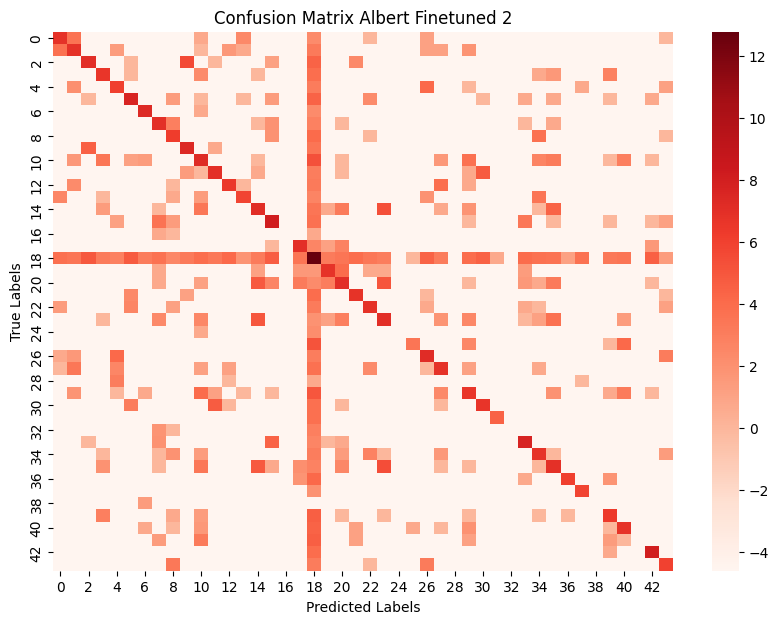

In [21]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf, cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Albert Finetuned 2')
plt.show()


In [8]:
distilbert_tuned = AutoModelForTokenClassification.from_pretrained('distilbert_finetuned')
albert_tuned = AutoModelForTokenClassification.from_pretrained('albert_finetuned')

In [9]:
model = KingBert(distilbert_tuned=distilbert_tuned, albert_tuned=albert_tuned)
state_dict = torch.load('model_state.pth')
model.load_state_dict(state_dict)
model.eval()

KingBert(
  (distilbert): DistilBertForTokenClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn)

In [10]:
dataset = aux.json_to_Dataset_ensemble("data/ensemble_test.json")

In [11]:
data = [i for i in dataset]

In [12]:
res = aux.compute_ensemble_metrics(model, data)
print(res)

Inference Progress:   0%|          | 0/4811 [00:00<?, ?it/s]

/Users/andreafabbricatore/Desktop/mac_bocconi/year 3/semester 2/AI/project/aux.py:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stacked_tensors1 = torch.stack([torch.tensor(i) for i in output1])
/Users/andreafabbricatore/Desktop/mac_bocconi/year 3/semester 2/AI/project/aux.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stacked_tensors2 = torch.stack([torch.tensor(i) for i in output2])
Inference Progress: 100%|██████████| 4811/4811 [12:46<00:00,  6.28it/s]


{'precision': 0.3628616363702864, 'recall': 0.40143238650157803, 'f1': 0.3811737585246374, 'accuracy': 0.9289059300726817, 'confusion_matrix': array([[ 697,   24,    0, ...,    0,    0,    0],
       [   2,  633,    0, ...,    0,    0,    0],
       [   0,    0, 1023, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0, 2774,    0],
       [   0,    0,    0, ...,    0,    0,  170]])}


In [13]:
conf = np.log(res['confusion_matrix'] + 0.01)

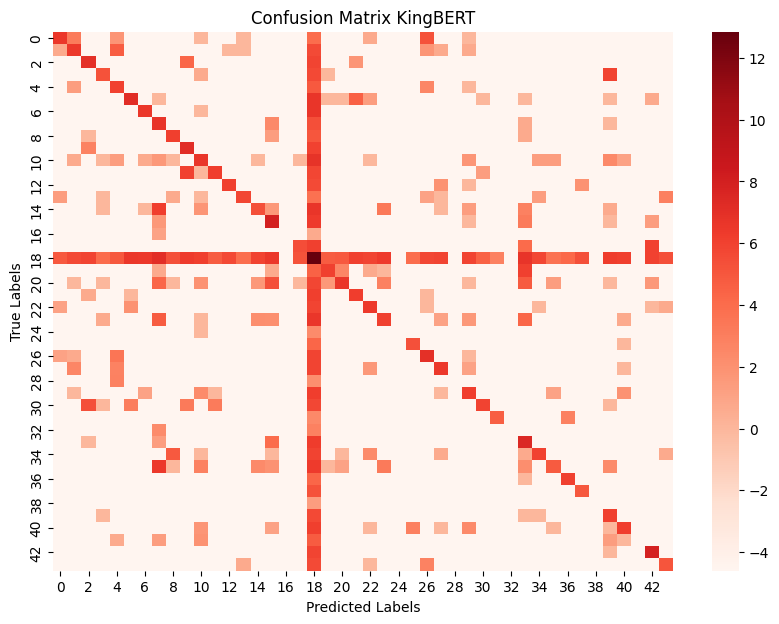

In [18]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf, cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix KingBERT')
plt.show()


In [15]:
model.alpha

Parameter containing:
tensor([0.4559, 0.4714, 0.4623, 0.4843, 0.4836, 0.4946, 0.4494, 0.5482, 0.5389,
        0.5174, 0.4891, 0.5062, 0.4962, 0.4947, 0.4990, 0.5642, 0.3211, 0.5558,
        0.5375, 0.4941, 0.5328, 0.4993, 0.5131, 0.4998, 0.3293, 0.3792, 0.5204,
        0.5098, 0.4599, 0.4734, 0.4943, 0.4348, 0.2828, 0.5257, 0.4587, 0.5047,
        0.3600, 0.4441, 0.3064, 0.4887, 0.4986, 0.4949, 0.3398, 0.5661, 0.5431,
        0.2914, 0.3014], requires_grad=True)